# Исследование рынка заведений общественного питания в Москве

Для исследования предоставлены данные о заведениях общественного питания в Москве.

Цель исследования: оценить текущее положение объектов общественного питания и дать рекомендации для открытия заведения с роботами-официантами.

Описание данных:
- id — идентификатор объекта;
- object_name — название объекта общественного питания;
- chain — сетевой ресторан;
- object_type — тип объекта общественного питания;
- address — адрес;
- number — количество посадочных мест.



## План работы

1. [Изучение данных](#1)

2. [Предобработка данных](#2)

    2.1 [Удаление дубликатов](#2.1)

    2.2 [Замена типа данных](#2.2)

3. [Анализ данных](#3)

    3.1 [Соотношение видов объектов общественного питания по количеству](#3.1)

    3.2 [Соотношение сетевых и несетевых заведений по количеству](#3.2)

    3.3 [Распределение сетевых и несетевых заведений по видам объектов общественного питания](#3.3)

    3.4 [Характеристика посадочных мест в сетевых заведениях](#3.4)

    3.5 [Среднее число мест по видам заведений](#3.5)

    3.6 [Выделение столбца с информацией об улицах](#3.6)

    3.7 [Топ-10 улиц по количеству объектов общественного питания](#3.7)

    3.8 [Число улиц с одним объектом общественного питания](#3.8)

    3.9 [Распределение посадочных мест для улиц с большим количеством заведений](#3.9)

4. [Общие выводы](#4)


<a name="1"><h2>1 Изучение данных</h2></a>

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import re
from io import BytesIO
import requests
import matplotlib
from IPython.display import Image
%config InlineBackend.figure_format = 'retina'
matplotlib.style.use('ggplot')
plt.rc('figure', figsize=(12, 6))
pd.options.display.max_rows = 300
pd.options.display.max_columns = 10
pd.options.display.max_colwidth = 150

Прочитаем файл rest_data и сохраним в переменной data:

In [2]:
data = pd.read_csv('/content/rest_data.csv')

Выведем на экран первые 10 строк и просмотрим общую информацию о таблице:

In [3]:
data.head(10)

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корпус 1",240
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
7,20957,Буфет МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",90
8,20958,КПФ СЕМЬЯ-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",150
9,28858,Столовая МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",120


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


В таблице 5 столбцов и 15366 записей, пропусков нет.

<div style="border: solid green 2px; padding: 20px">

**Выводы**
* В столбцах 'object_name' и 'address' слова записаны в разном регистре, также в названиях заведений встречаются записи содержащие различные символы и сокращения, поэтому их следует привести к одному виду.
* Так как в работе потребуется проводить расчеты с колонкой 'chain', то удобнее заменить формат на булевый тип.</div>

<a name="2"><h2>2 Предобработка данных</h2></a>

Проверим написание типов объектов в столбце 'object_type':

In [5]:
data['object_type'].sort_values().unique()

array(['бар', 'буфет', 'закусочная', 'кафе', 'кафетерий',
       'магазин (отдел кулинарии)', 'предприятие быстрого обслуживания',
       'ресторан', 'столовая'], dtype=object)

Названия корректны, прописных букв нет.

Переведём названия в нижний регистр в столбцах 'object_name' и 'address':

In [6]:
data['object_name'] = data['object_name'].str.lower()
data['address'] = data['address'].str.lower()

Так как встречаются строчки, где названия написаны в кавычках, то создадим функцию для извлечения таких слов:

In [7]:
def extract_word(name):
    match = re.search('«[А-я ]+»', name)
    if match is not None: 
        return match.group()
    else:
        return name

Обновим записи в столбце 'object_name':

In [8]:
data['object_name'] = [extract_word(str(name)) for name in data['object_name']]

Проверим результат:

In [9]:
data['object_name'].head(10)

0                     сметана
1                      родник
2                  «академия»
3                  пиццетория
4           «вишневая метель»
5    стол. при гоу сош № 1051
6                    брусника
7                 буфет мтуси
8                 кпф семья-1
9              столовая мтуси
Name: object_name, dtype: object

Уберём кавычки методом replace:

In [10]:
data['object_name'] = data['object_name'].str.replace('«', '')
data['object_name'] = data['object_name'].str.replace('»', '')

Удалим из столбца различные символы:

In [11]:
data['object_name'] = [re.sub('\.|\&|\(|\)|\№',' ', str(name)) for name in data['object_name']]

Добавим пробел между цифрами и буквами:

In [12]:
data['object_name'] = [re.sub('(\d+(\.\d+)?)', r' \1 ', str(name)) for name in data['object_name']]

Уберем лишние пробелы:

In [13]:
data['object_name'] = [re.sub('\s+',' ', str(name)) for name in data['object_name']]

Просмотрим список ещё раз:

In [14]:
data['object_name'].head(10)

0                   сметана
1                    родник
2                  академия
3                пиццетория
4           вишневая метель
5    стол при гоу сош 1051 
6                  брусника
7               буфет мтуси
8             кпф семья- 1 
9            столовая мтуси
Name: object_name, dtype: object

В списке остались записи, где названия очень похожи, но отличаются из-за наличия или отсутствия пробела, тире или разницы в одной букве, но нельзя утверждать, что это одни и те же компании, поэтому оставим названия в таком виде.

<a name="2.1"><h3>2.1 Удаление дубликатов</h3></a>

Проверим, содержит ли таблица явные дубликаты:

In [15]:
data.duplicated().sum()

0

Явных дубликатов нет, проверим таблицу без столбца с индексом:

In [16]:
len(data[data.duplicated(subset=['object_name', 'chain', 'object_type', 'address', 'number'])])

87

Удалим найденные дубликаты:

In [17]:
data = data.drop_duplicates(subset=['object_name', 'chain', 'object_type', 'address', 'number']).reset_index(drop=True)

Проверим, что записи были удалены:

In [18]:
data.duplicated(subset=['object_name', 'chain', 'object_type', 'address', 'number']).sum()

0

<a name="2.2"><h3>2.2 Замена типа данных</h3></a>

Поменяем формат в колонке 'chain', заменим 'да' на True и 'нет' на False:

In [19]:
data['chain'] = data['chain'] == 'да'

Проверим результат:

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15279 entries, 0 to 15278
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15279 non-null  int64 
 1   object_name  15279 non-null  object
 2   chain        15279 non-null  bool  
 3   object_type  15279 non-null  object
 4   address      15279 non-null  object
 5   number       15279 non-null  int64 
dtypes: bool(1), int64(2), object(3)
memory usage: 611.9+ KB


In [21]:
data.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,False,кафе,"город москва, улица егора абакумова, дом 9",48
1,77874,родник,False,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35
2,24309,академия,False,кафе,"город москва, абельмановская улица, дом 6",95
3,21894,пиццетория,True,кафе,"город москва, абрамцевская улица, дом 1",40
4,119365,вишневая метель,False,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50


<div style="border: solid green 2px; padding: 20px">
    
**Выводы**
    
 * Привели названия объектов общественного питания к одному виду.
 * Проверили и удалили дубликаты.
 * Изменили формат в колонке 'chain' на булевый тип.</div>

<a name="3"><h2>3 Анализ данных</h2></a>

<a name="3.1"><h3>3.1 Соотношение видов объектов общественного питания по количеству</h3></a>

Напишем функцию для создания сводной таблицы, которая будет подсчитывать количество объектов общественного питания по выбранной группе и их соотношение:

In [22]:
def create_table(data, group):
    table = data.groupby(group)['id'].agg(['count'])
    table['ratio'] = (table['count']/len(data))
    table = table.sort_values(by='count', ascending=False)
    return table

Обратимся к функции и выведем таблицу сгруппированную по видам заведений:

In [23]:
ratio_types = create_table(data, 'object_type')
ratio_types.style.format({'ratio':'{:,.2%}'})

,count,ratio
object_type,,
кафе,6070,39.73%
столовая,2584,16.91%
ресторан,2282,14.94%
предприятие быстрого обслуживания,1897,12.42%
бар,855,5.60%
буфет,575,3.76%
кафетерий,395,2.59%
закусочная,348,2.28%
магазин (отдел кулинарии),273,1.79%


Построим график:

In [24]:
fig = go.Figure(go.Pie(labels=ratio_types.index, values=ratio_types['ratio'],
                       title = "Соотношение видов объектов общественного питания"))
fig.show()

<div style="border: solid green 2px; padding: 20px">
    
**Вывод**

Большинство заведений относятся к виду кафе, доля таких заведений составляет 39,7%.</div>

<a name="3.2"><h3>3.2 Соотношение сетевых и несетевых заведений по количеству</h3></a>

Создадим сводную таблицу с разделением на сетевые и несетевые заведения:

In [25]:
ratio_chain = create_table(data, 'chain')
ratio_chain.style.format({'ratio':'{:,.2%}'})

,count,ratio
chain,,
False,12315,80.60%
True,2964,19.40%


Построим график:

In [26]:
fig = go.Figure(go.Pie(labels=ratio_chain.index, values=ratio_chain['count'], 
     title = "Соотношение сетевых и несетевых заведений по количеству"))
fig.show()

<div style="border: solid green 2px; padding: 20px">
    
**Вывод**
    
Несетевых заведений существенно больше, чем сетевых, доля которых составляет 19,4%.</div>

<a name="3.3"><h3>3.3 Распределение сетевых и несетевых заведений по видам объектов общественного питания</h3></a>

Создадим функцию для построения сводной таблицы по видам объектов общественного питания и выбранной подгруппе:

In [27]:
def table_groups(data, group, table_for_merge):
    table = data.groupby(['object_type', group])['id'].agg(['count']).reset_index()
    table = table.merge(table_for_merge['count'], on = 'object_type')
    table['ratio'] = table['count_x']/table['count_y']
    return table

Обратимся к функции, поменяем название колонок и выведем таблицу в разрезе сетевых или несетевых заведений:

In [28]:
type_chain = table_groups(data, 'chain', ratio_types)
type_chain.columns = ['object_type','chain','count','total_in_type','ratio']
type_chain.style.format({'ratio':'{:,.2%}'})

,object_type,chain,count,total_in_type,ratio
0,бар,False,818,855,95.67%
1,бар,True,37,855,4.33%
2,буфет,False,564,575,98.09%
3,буфет,True,11,575,1.91%
4,закусочная,False,292,348,83.91%
5,закусочная,True,56,348,16.09%
6,кафе,False,4674,6070,77.00%
7,кафе,True,1396,6070,23.00%
8,кафетерий,False,343,395,86.84%
9,кафетерий,True,52,395,13.16%


Для вывода графиков напишем функцию для переноса слов по пробелам:

In [29]:
def split_by_spaces(column):
    return [re.sub('\s+', '<br>', str(name)) for name in column]  

Применим функцию:

In [30]:
type_chain['object_type'] = split_by_spaces(type_chain['object_type'])

Выведем график:

In [31]:
fig = px.bar(type_chain, x="object_type", y="count", color="chain", text="count", title="Распределение сетевых и несетевых заведений по видам")
fig.update_layout(xaxis_title="Виды заведений", yaxis_title="Количество заведений")
fig.show()

<div style="border: solid green 2px; padding: 20px">
    
**Вывод**
   
Сетевые заведения характерны для предприятий быстрого обслуживания, их доля составляет 41.54%, магазинов с отделом кулинарии (28.57%), ресторанов (23.79%) и кафе (23.00%), в других видах заведений сетевых очень мало, особенно редко встречаются у столовых.</div>

<a name="3.4"><h3>3.4 Характеристика посадочных мест в сетевых заведениях</h3></a>

Для разделения заведений по категориям в зависимости от количества посадочных мест обратимся к методу describe:

In [32]:
data['number'].describe().apply("{0:.0f}".format)

count    15279
mean        60
std         75
min          0
25%         14
50%         40
75%         80
max       1700
Name: number, dtype: object

Посмотрим количество заведений, у которых нет мест:

In [33]:
len(data.query('number == 0'))

1588

Посмотрим на их распределение:

In [34]:
data.query('number == 0').groupby('object_type')['id'].agg('count').sort_values(ascending=False)

object_type
предприятие быстрого обслуживания    690
кафе                                 306
закусочная                           181
магазин (отдел кулинарии)            145
кафетерий                            111
буфет                                 64
ресторан                              44
бар                                   28
столовая                              19
Name: id, dtype: int64

Больше всего заведений без мест на предприятиях быстрого обсуживания. Это могут быть объекты, которые работают на вынос заказов.

Выделим для них отдельную категорию "без мест", если количество мест равно нулю, оставшиеся заведения поделим на две группы по медиане, которая равна 40:

In [35]:
def number_of_seats(row):  
    if row['number'] == 0:
        return 'без мест'
    elif row['number'] <= 40:
        return 'мало мест'   
    else:
        return 'много мест'

Добавим новый столбец и применим функцию 'number_of_seats':

In [36]:
data['number_group'] = data.apply(number_of_seats, axis=1)

Проверим, что столбец был добавлен и названия распределены правильно:

In [37]:
data.head(10)

,id,object_name,chain,object_type,address,number,number_group
0,151635,сметана,False,кафе,"город москва, улица егора абакумова, дом 9",48,много мест
1,77874,родник,False,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,мало мест
2,24309,академия,False,кафе,"город москва, абельмановская улица, дом 6",95,много мест
3,21894,пиццетория,True,кафе,"город москва, абрамцевская улица, дом 1",40,мало мест
4,119365,вишневая метель,False,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50,много мест
5,27429,стол при гоу сош 1051,False,столовая,"город москва, абрамцевская улица, дом 15, корпус 1",240,много мест
6,148815,брусника,True,кафе,"город москва, переулок сивцев вражек, дом 6/2",10,мало мест
7,20957,буфет мтуси,False,столовая,"город москва, авиамоторная улица, дом 8, строение 1",90,много мест
8,20958,кпф семья- 1,False,столовая,"город москва, авиамоторная улица, дом 8, строение 1",150,много мест
9,28858,столовая мтуси,False,столовая,"город москва, авиамоторная улица, дом 8, строение 1",120,много мест


Выделим таблицу с сетевыми заведениями:

In [38]:
data_chain = data.query('chain == True')

Посмотрим на общее распределение по категориям:

In [39]:
data_chain.groupby('number_group')['id'].agg(['count']).reset_index()

,number_group,count
0,без мест,265
1,мало мест,1320
2,много мест,1379


Немного больше заведений с большим количеством мест.

Посмотрим на количество и соотношение сетевых заведений:

In [40]:
chain_count = create_table(data_chain, 'object_type')
chain_count.style.format({'ratio':'{:,.2%}'})

,count,ratio
object_type,,
кафе,1396,47.10%
предприятие быстрого обслуживания,788,26.59%
ресторан,543,18.32%
магазин (отдел кулинарии),78,2.63%
закусочная,56,1.89%
кафетерий,52,1.75%
бар,37,1.25%
буфет,11,0.37%
столовая,3,0.10%


Наибольшее число сетевых заведений относится к кафе.

Сгруппируем по названию заведений, исключив сети, которые состоят из 1 заведения:

In [41]:
object_name_group = data.groupby('object_name')['id'].agg(['count']).query('count > 1')
object_name_group.columns= ['count_object']

Обратимся к методу describe для разбиения на категории по количеству заведений в сети:

In [42]:
object_name_group['count_object'].describe().apply("{0:.0f}".format)

count    1223
mean        6
std        18
min         2
25%         2
50%         2
75%         4
max       322
Name: count_object, dtype: object

У половины объектов 2 точки, у 75% менее 4 и 25% более 4 заведений. Разделим заведения по количеству сетей на группы "мало заведений", если в сети до 4 объектов и "много заведений", если больше 4:

In [43]:
def number_of_object(row):  
    if row['count_object'] < 4:
        return 'мало заведений'  
    else:
        return 'много заведений'

Сначала объединим таблицы data_chain и object_name_group:

In [44]:
data_chain = data_chain.merge(object_name_group, on = 'object_name')
data_chain.head()

,id,object_name,chain,object_type,address,number,number_group,count_object
0,21894,пиццетория,True,кафе,"город москва, абрамцевская улица, дом 1",40,мало мест,2
1,135770,пиццетория,True,кафе,"город москва, дубнинская улица, дом 53, корпус 1",25,мало мест,2
2,148815,брусника,True,кафе,"город москва, переулок сивцев вражек, дом 6/2",10,мало мест,10
3,111162,брусника,True,кафе,"город москва, проспект мира, дом 49",40,мало мест,10
4,77314,брусника,True,кафе,"город москва, улица маросейка, дом 6-8, строение 1",62,много мест,10


Добавим в таблицу столбец для категорий и применим функцию:

In [45]:
data_chain['count_object_group'] = data_chain.apply(number_of_object, axis=1)

Проверим, что столбец был добавлен:

In [46]:
data_chain.head()

,id,object_name,chain,object_type,address,number,number_group,count_object,count_object_group
0,21894,пиццетория,True,кафе,"город москва, абрамцевская улица, дом 1",40,мало мест,2,мало заведений
1,135770,пиццетория,True,кафе,"город москва, дубнинская улица, дом 53, корпус 1",25,мало мест,2,мало заведений
2,148815,брусника,True,кафе,"город москва, переулок сивцев вражек, дом 6/2",10,мало мест,10,много заведений
3,111162,брусника,True,кафе,"город москва, проспект мира, дом 49",40,мало мест,10,много заведений
4,77314,брусника,True,кафе,"город москва, улица маросейка, дом 6-8, строение 1",62,много мест,10,много заведений


Напишем функцию для проверки событий по количеству мест и заведений в сети:

In [47]:
def check_event(group_count_seats, group_count_object):
    table = data_chain.query('number_group == @group_count_seats and count_object_group == @group_count_object')
    return table['id'].count()

Применим функцию и посмотрим вероятность какого события выше:

In [48]:
check_event("много мест", "мало заведений")

120

In [49]:
check_event("мало мест", "много заведений")

1131

In [50]:
check_event("мало мест", "мало заведений")

90

In [51]:
check_event("много мест", "много заведений")

1141

<div style="border: solid green 2px; padding: 20px">
    
**Вывод**
    
Чуть выше вероятность встретить сеть с большим числом посадочных мест и большим числом заведений в сети, вероятность события встретить сеть с небольшим числом посадочных мест и большим числом заведений в сети почти такая же высокая. Реже всего можно встретить заведение с небольшим числом посадочных мест и небольшим числом заведений в сети.</div>

<a name="3.5"><h3>3.5 Среднее число мест по видам заведений</h3></a>

Подсчитаем среднее число мест по видам заведений:

In [52]:
mean_number_seats = data.groupby('object_type')['number'].agg(['median']).round(0).sort_values(by='median', ascending=False).reset_index()
mean_number_seats

,object_type,median
0,столовая,103.0
1,ресторан,80.0
2,бар,35.0
3,буфет,32.0
4,кафе,30.0
5,кафетерий,6.0
6,предприятие быстрого обслуживания,6.0
7,закусочная,0.0
8,магазин (отдел кулинарии),0.0


У половины закусочных и магазинов с отделом кулинарии нет мест. Посмотрим на распределение в этих заведениях:

In [53]:
data.query('object_type in ("закусочная","магазин (отдел кулинарии)")').groupby('object_type')['number'].describe().round()

,count,mean,std,min,25%,50%,75%,max
object_type,,,,,,,,
закусочная,348.0,8.0,17.0,0.0,0.0,0.0,10.0,216.0
магазин (отдел кулинарии),273.0,6.0,10.0,0.0,0.0,0.0,8.0,50.0


В закусочных и магазинах с отделом кулинарии у 75% заведений менее чем 10 и 8 мест соответственно.

Для вывода графиков разделим длинные названия по пробелам:

In [54]:
mean_number_seats['object_type'] = split_by_spaces(mean_number_seats['object_type'])

Построим график:

In [55]:
fig = px.bar(mean_number_seats.query('median > 0'), x='object_type', y='median', text='median', title='Среднее число мест по видам заведений')
fig.update_layout(width=800, height=600, xaxis_title="Виды заведений", yaxis_title="Среднее количество мест")
fig.show()

<div style="border: solid green 2px; padding: 20px">
    
**Вывод**
    
Столовая предоставляет в среднем самое большое количество посадочных мест, на втором месте ресторан.</div>

<a name="3.6"><h3>3.6 Выделение столбца с информацией об улицах</h3></a>

Добавим в таблицу data столбец с информацией об улице из столбца 'address'. Для этого разделим столбец с адресом по запятой на колонки методом split и возьмем столбец 1:

In [56]:
data['street'] = data['address'].str.split(',', expand=True)[1]

Проверим, что столбец с улицами был добавлен:

In [57]:
data.head(10)

,id,object_name,chain,object_type,address,number,number_group,street
0,151635,сметана,False,кафе,"город москва, улица егора абакумова, дом 9",48,много мест,улица егора абакумова
1,77874,родник,False,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,мало мест,улица талалихина
2,24309,академия,False,кафе,"город москва, абельмановская улица, дом 6",95,много мест,абельмановская улица
3,21894,пиццетория,True,кафе,"город москва, абрамцевская улица, дом 1",40,мало мест,абрамцевская улица
4,119365,вишневая метель,False,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50,много мест,абрамцевская улица
5,27429,стол при гоу сош 1051,False,столовая,"город москва, абрамцевская улица, дом 15, корпус 1",240,много мест,абрамцевская улица
6,148815,брусника,True,кафе,"город москва, переулок сивцев вражек, дом 6/2",10,мало мест,переулок сивцев вражек
7,20957,буфет мтуси,False,столовая,"город москва, авиамоторная улица, дом 8, строение 1",90,много мест,авиамоторная улица
8,20958,кпф семья- 1,False,столовая,"город москва, авиамоторная улица, дом 8, строение 1",150,много мест,авиамоторная улица
9,28858,столовая мтуси,False,столовая,"город москва, авиамоторная улица, дом 8, строение 1",120,много мест,авиамоторная улица


Удалим пробелы в начале названий, которые остались после разделения по запятой:

In [58]:
data['street'] = data['street'].str.lstrip()

Уберем из таблицы строки, содержащие в названиях улиц слова 'город', 'поселение', 'посёлок', 'деревня', 'дом' и 'владение':

In [59]:
data = (data[data['street'].str.contains('город|поселение|посёлок|деревня|дом|владение')==False]).reset_index(drop=True)

Проверим список:

In [60]:
data['street'].head(10)

0     улица егора абакумова
1          улица талалихина
2      абельмановская улица
3        абрамцевская улица
4        абрамцевская улица
5        абрамцевская улица
6    переулок сивцев вражек
7        авиамоторная улица
8        авиамоторная улица
9        авиамоторная улица
Name: street, dtype: object

<div style="border: solid green 2px; padding: 20px">
    
**Вывод**

В таблицу data добавили столбец с названиями улиц для дальнейшего анализа.</div>

<a name="3.7"><h3>3.7 Топ-10 улиц по количеству объектов общественного питания</h3></a>

Создадим сводную таблицу с топ улицами по количеству объектов общественного питания:

In [61]:
top_street = data.groupby(['street'])['id'].agg(['count']).sort_values(by='count', ascending=False).reset_index().head(10)
top_street

,street,count
0,проспект мира,203
1,профсоюзная улица,181
2,ленинградский проспект,170
3,пресненская набережная,167
4,варшавское шоссе,161
5,ленинский проспект,147
6,проспект вернадского,128
7,кутузовский проспект,114
8,каширское шоссе,111
9,кировоградская улица,108


Построим график:

In [62]:
fig = px.bar(top_street, x='street', y='count', text='count', title='Топ-10 улиц по количеству объектов общественного питания')
fig.update_layout(width=900,height=500, xaxis_title="Название улиц", yaxis_title="Количество заведений")
fig.show()

Загрузим справочник с улицами и районами Москвы, чтобы посмотреть к каким районам относятся топ-10 улиц:

In [63]:
spreadsheet_id = '1NGkL8HjVOCzLGXOzyHAdPycBbLNew3eNwY6nUK5wQ8c'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
directory = pd.read_csv(BytesIO(r.content))
directory.head(10)

,Справочник улиц Мосгаз : streets,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,A,B,C,D
1,1.0,streetname,areaid,okrug,area
2,2.0,Выставочный переулок,17,ЦАО,Пресненский район
3,3.0,улица Гашека,17,ЦАО,Пресненский район
4,4.0,Большая Никитская улица,17,ЦАО,Пресненский район
5,5.0,Глубокий переулок,17,ЦАО,Пресненский район
6,6.0,Большой Гнездниковский переулок,17,ЦАО,Пресненский район
7,7.0,Малый Гнездниковский переулок,17,ЦАО,Пресненский район
8,8.0,Большая Грузинская улица,17,ЦАО,Пресненский район
9,9.0,Малая Грузинская улица,17,ЦАО,Пресненский район


Удалим первые две строчки и столбцы 'Справочник улиц Мосгаз : streets' и 'Unnamed: 2', а также поменяем названия столбцов:

In [64]:
directory.drop([0,1], inplace=True)
directory.drop(['Справочник улиц Мосгаз : streets','Unnamed: 2'], axis=1, inplace=True)
directory = directory.reset_index(drop=True)
directory.columns = ['street','okrug','district']

Приведём записи в столбцах к нижнему регистру:

In [65]:
list_column = ['street', 'okrug','district']
for column in list_column:
    directory[column] = directory[column].str.lower()

Проверим результат:

In [66]:
directory.head(10)

,street,okrug,district
0,выставочный переулок,цао,пресненский район
1,улица гашека,цао,пресненский район
2,большая никитская улица,цао,пресненский район
3,глубокий переулок,цао,пресненский район
4,большой гнездниковский переулок,цао,пресненский район
5,малый гнездниковский переулок,цао,пресненский район
6,большая грузинская улица,цао,пресненский район
7,малая грузинская улица,цао,пресненский район
8,грузинская площадь,цао,пресненский район
9,улица грузинский вал,цао,пресненский район


Объединим таблицы по названию улиц:

In [67]:
district_top_street = pd.merge(top_street, directory, on ='street', how='left')
district_top_street = district_top_street.groupby(['street','okrug']).agg({'district':'unique'})
district_top_street['count_district'] = district_top_street['district'].str.len()
district_top_street

district  \
street                 okrug                                                                                                                                            
варшавское шоссе       юао    [район чертаново центральное, район чертаново северное, район чертаново южное, донской район, район нагатино-садовники, нагорный район]   
                       юзао                                                                                               [район северное бутово, район южное бутово]   
каширское шоссе        юао                      [район москворечье-сабурово, район нагатино-садовники, район орехово-борисово южное, район орехово-борисово северное]   
кировоградская улица   юао                                                             [район чертаново центральное, район чертаново северное, район чертаново южное]   
кутузовский проспект   зао                                                                                                 [район дорогомилово, район фили-давыдково]   
ленинградский проспект сао                                                                            [район аэропорт, район беговой, хорошевский район, район сокол]   
ленинский проспект     зао                                                                                     [район проспект вернадского, район тропарево-никулино]   
                       цао                                                                                                                           [район якиманка]   
                       юао                                                                                                                            [донской район]   
                       юзао                                                            [район гагаринский, ломоносовский район, обручевский район, район теплый стан]   
пресненская набережная цао                                                                                                                        [пресненский район]   
проспект вернадского   зао                                                                      [район проспект вернадского, район раменки, район тропарево-никулино]   
                       юзао                                                                                                  [район гагаринский, ломоносовский район]   
проспект мира          свао                          [алексеевский район, ярославский район, район марьина роща, останкинский район, район ростокино, район свиблово]   
                       цао                                                                                                                          [мещанский район]   
профсоюзная улица      юзао                               [академический район, район черемушки, район ясенево, район коньково, обручевский район, район теплый стан]   

                              count_district  
street                 okrug                  
варшавское шоссе       юао                 6  
                       юзао                2  
каширское шоссе        юао                 4  
кировоградская улица   юао                 3  
кутузовский проспект   зао                 2  
ленинградский проспект сао                 4  
ленинский проспект     зао                 2  
                       цао                 1  
                       юао                 1  
                       юзао                4  
пресненская набережная цао                 1  
проспект вернадского   зао                 3  
                       юзао                2  
проспект мира          свао                6  
                       цао                 1  
профсоюзная улица      юзао                6

<div style="border: solid green 2px; padding: 20px">
    
**Вывод**
    
Большинство улиц расположены в районах, которые не относятся к центру города, возможно это связано с высокой ценой аренды помещений в центральном округе.</div>

<a name="3.8"><h3>3.8 Число улиц с одним объектом общественного питания</h3></a>

Подсчитаем количество улиц с одним объектом общественного питания:

In [68]:
number_objects = data.groupby(['street'])['id'].agg(['count']).reset_index()
one_object = number_objects.query('count == 1')
print("Количество улиц с одним объектом: ", len(one_object))

Количество улиц с одним объектом:  537


Объединим таблицу one_object со справочником по улицам и районам:

In [69]:
district_one_object = pd.merge(one_object, directory, on ='street', how='left')
district_one_object.drop('count', axis = 1, inplace=True)
district_one_object.head()

,street,okrug,district
0,1-й балтийский переулок,сао,район аэропорт
1,1-й басманный переулок,цао,басманный район
2,1-й басманный переулок,цао,красносельский район
3,1-й ботанический проезд,свао,район свиблово
4,1-й вешняковский проезд,ювао,рязанский район


Выведем топ-10 районов по количеству улиц с одним заведением:

In [70]:
district_one_object.groupby('district')['street'].agg(['count']).sort_values(by='count', ascending=False).reset_index().head(10)

,district,count
0,таганский район,27
1,район хамовники,26
2,басманный район,25
3,тверской район,20
4,пресненский район,19
5,район марьина роща,18
6,район арбат,17
7,мещанский район,16
8,район сокольники,15
9,район замоскворечье,14


<div style="border: solid green 2px; padding: 20px">
    
**Вывод**
    
Всего 537 улиц с одним объектом общественного питания, больше всего таких улиц в Таганском районе, при этом все кроме района Сокольники расположены в центре города.</div>

<a name="3.9"><h3>3.9 Распределение посадочных мест для улиц с большим количеством заведений</h3></a>

Создадим список с топ улицами по количеству заведений:

In [71]:
list_top_street = top_street['street']

Сделаем срез таблицы по этим улицам:

In [72]:
data_top_street = data.query('street in @list_top_street').reset_index(drop=True)
data_top_street.head(10)

,id,object_name,chain,object_type,address,number,number_group,street
0,155973,андерсон,True,кафе,"город москва, варшавское шоссе, дом 2",150,много мест,варшавское шоссе
1,23618,кафе subway,True,кафе,"город москва, варшавское шоссе, дом 7, корпус 1",36,мало мест,варшавское шоссе
2,155852,ламаджо,False,кафе,"город москва, варшавское шоссе, дом 29",30,мало мест,варшавское шоссе
3,152556,шаурма в пите,False,предприятие быстрого обслуживания,"город москва, варшавское шоссе, дом 72, корпус 2",0,без мест,варшавское шоссе
4,120658,выпечка,False,кафетерий,"город москва, варшавское шоссе, дом 100",2,мало мест,варшавское шоссе
5,26279,макдоналдс,True,кафе,"город москва, варшавское шоссе, дом 143а",70,много мест,варшавское шоссе
6,141687,пироговая рогова,False,кафе,"город москва, проспект вернадского, дом 9/10",42,много мест,проспект вернадского
7,148853,кафе контдитерская кузина,False,кафе,"город москва, проспект вернадского, дом 11/19",5,мало мест,проспект вернадского
8,149149,суши wok,True,кафе,"город москва, проспект вернадского, дом 11/19",8,мало мест,проспект вернадского
9,128511,аморе,False,кафе,"город москва, проспект вернадского, дом 11/19",10,мало мест,проспект вернадского


Напишем функцию для построения графика распределения по количеству посадочных мест, чтобы рассмотреть данные с учетом всех мест и без учета выбросов:

In [73]:
def distribution_seats(table):
    plt.figure(figsize=(15,10))
    boxplot = sns.boxplot(x="street", y="number", data = table)
    plt.title('Распределение посадочных мест')
    plt.xlabel("Название улиц", fontsize=12)
    plt.ylabel("Количество мест", fontsize=12)
    plt.xticks(rotation=45)
    return boxplot

Обратимся к функции:

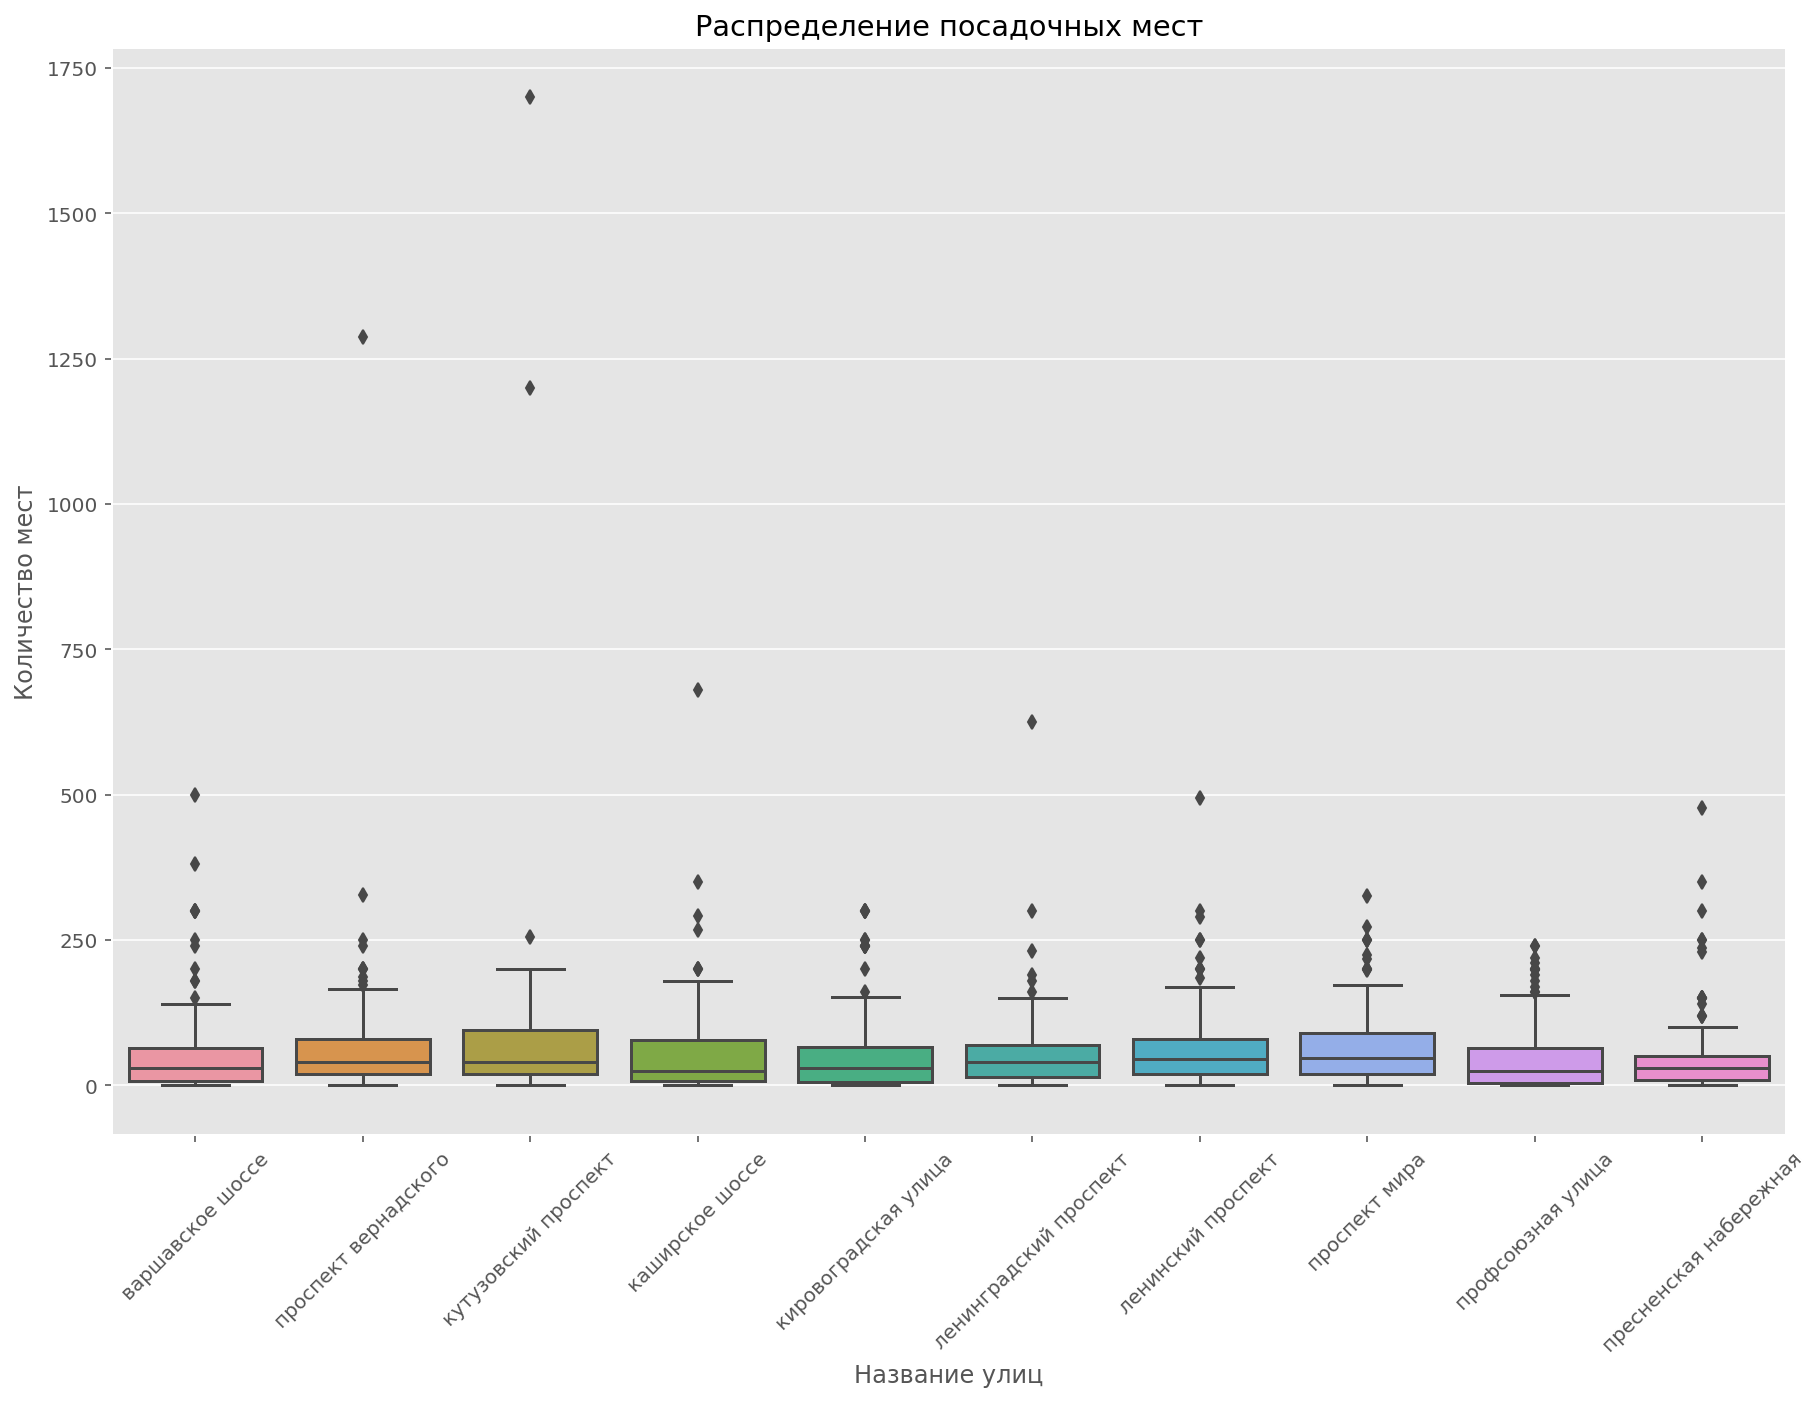

In [74]:
distribution_seats(data_top_street)
plt.show()

Заведение с максимальным значением в 1700 мест находится на Кутузовском проспекте, но у большинства число мест не превышает 300, поэтому поставим лимит по этому значению:

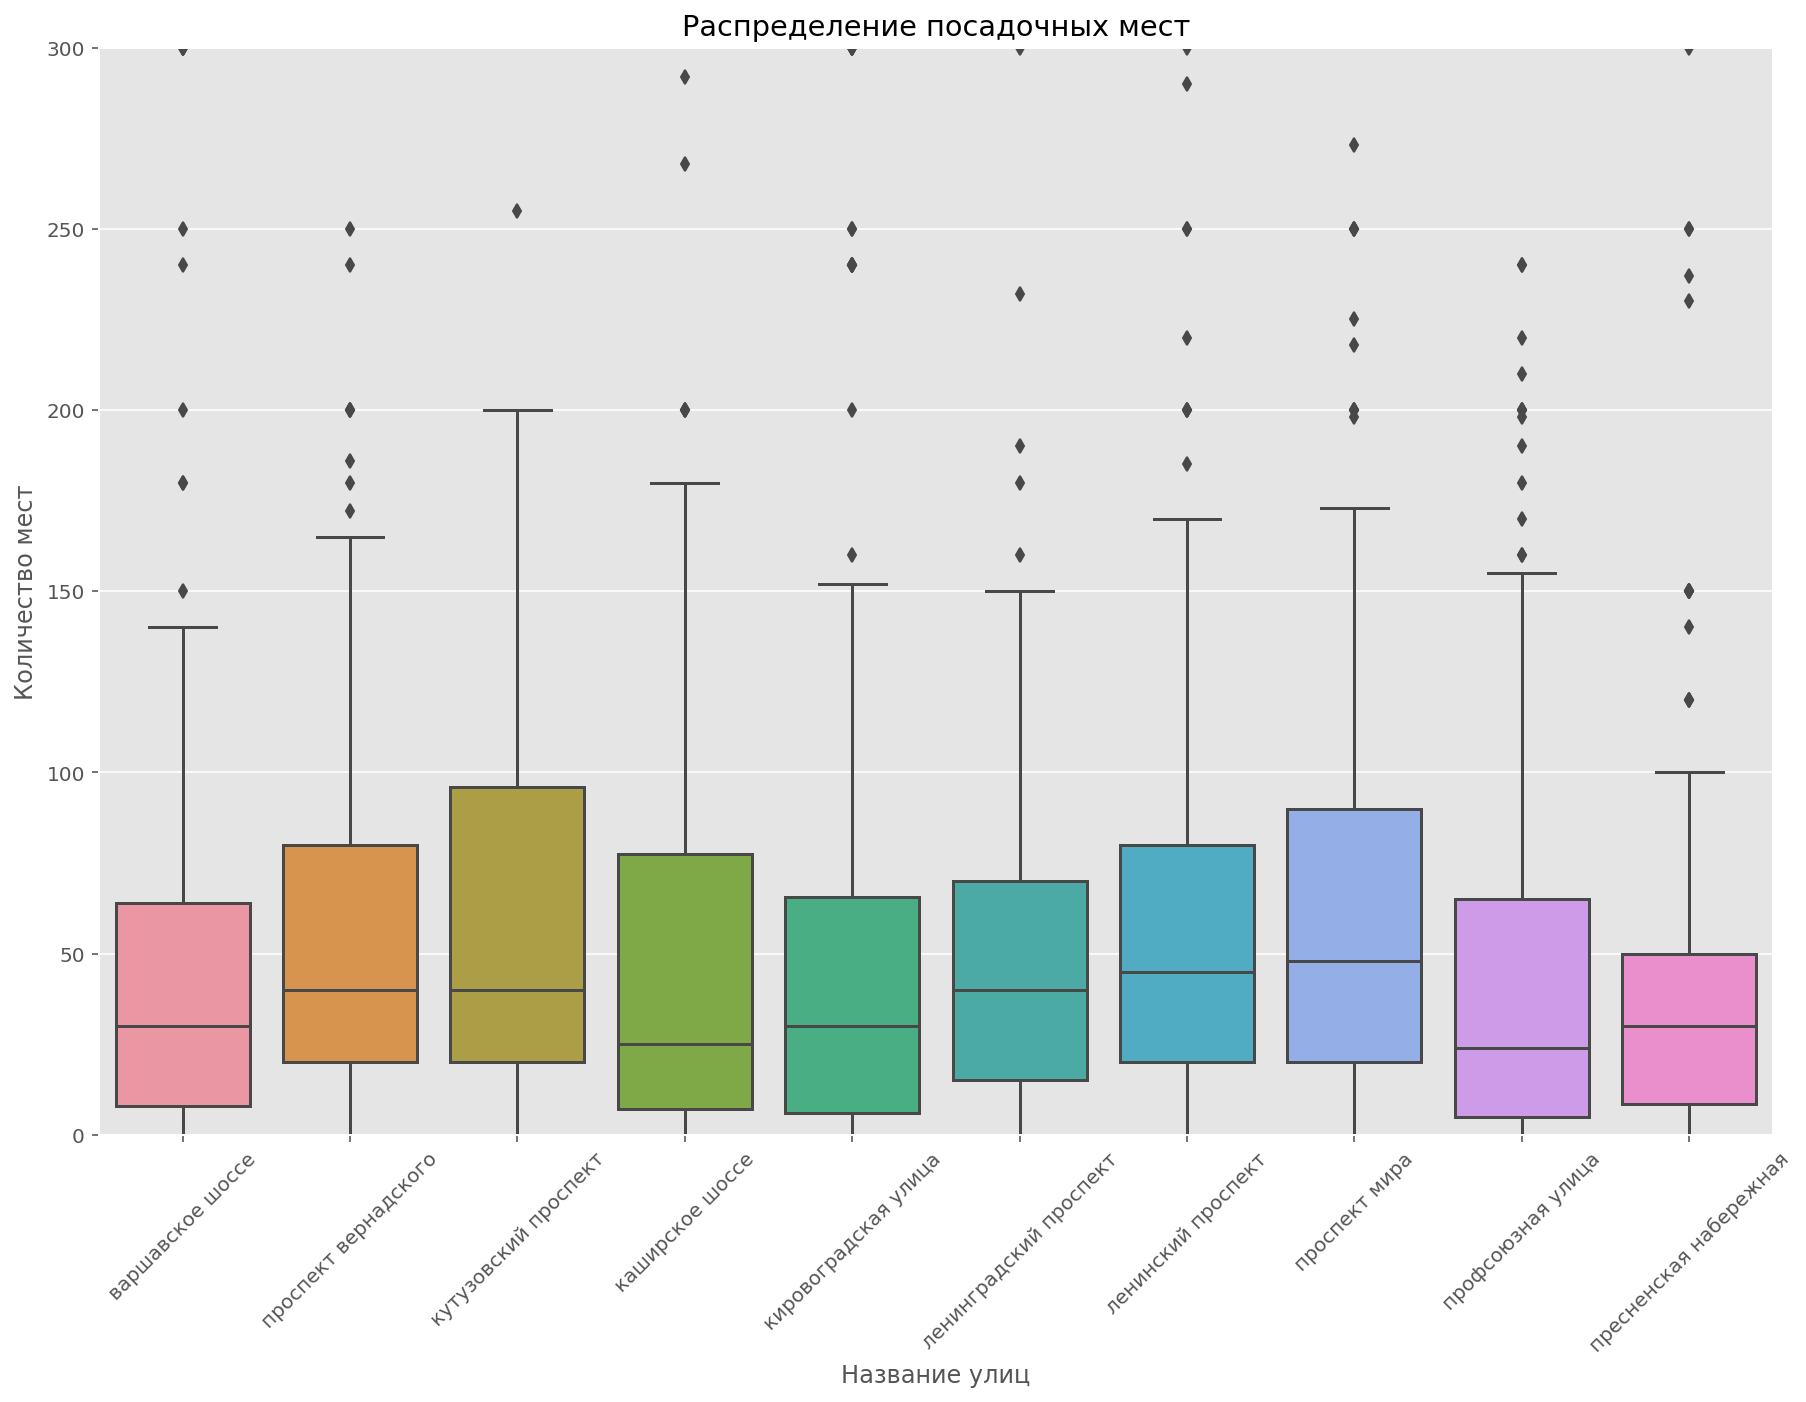

In [75]:
distribution_seats(data_top_street)
plt.ylim(0, 300)
plt.show()

<div style="border: solid green 2px; padding: 20px">
    
**Выводы**
    
Межквартильный размах по всем заведениям не больше 100 мест. Наиболее широкий диапазон распределения на Кутузовском проспекте, также широкий диапазон можно выделить на Каширском шоссе и Проспекте Мира. Самый маленький межквартильный размах на Пресненской набережной. Медиана по топ-улицам не превышает 50 мест.</div>

<a name="4"><h2>4 Общие выводы</h2></a>

В результате работы проанализировали данные о заведениях общественного питания в Москве и сделали следующие выводы:

 * Большую долю рынка по общественному питанию занимают кафе (39,7%), на втором и третьем месте столовые и рестораны, их доля составляет 16.91% и 14.94% соответственно. Меньше всего магазинов с отделом кулинарии (1.79%).
 * Сетевых заведений значительно меньше, их доля равна 19,4%.
 * Самый большой процент сетевых заведений на предприятиях быстрого обслуживания, 41.54% от общего числа заведений этого вида. Также сетевые заведения характерны для магазинов с отделом кулинарии (28.57%), ресторанов (23.79%) и кафе (23.00%). По соотношению среди сетевых заведений почти половину занимают кафе (47%).
 * Для сетевых заведений характерно много заведений с большим числом посадочных мест, а также мало посадочных мест и много заведений. 
 * Самое большое среднее число мест у столовых (103), на втором месте рестораны с количеством 80 мест. В кафе в среднем 30 мест, а в закусочных и в магазинах с отделом кулинарии у половины мест нет.
 * Больше всего заведений на Проспекте Мира (203 объекта), далее по числу объектов идут Профсоюзная улица (181) и Ленинградский проспект (170). На последнем месте среди топ-10 улиц по количеству заведений Кировоградская улица с числом 108 объектов.
 * Общее количество улиц с одним заведением 537. Данные улицы были соотнесены с районами Москвы и выделены топ-10 по числу улиц. Наибольшее количество расположено в центральной части города, при этом первые три места занимают Таганский район (27), район Хамовникии (26) и Басманный район (25).
 * Наибольший межквартильный размах по числу посадочных мест на кутузовском проспекте, но число мест по всем топ-улицам не превышает отметку 100. Медиана варьируется примерно от 25 до 48 мест.
    
Рекомендации:
   
Так как планируется открытие нестандартного объекта общественного питания, то скорее всего посетители будут приходить в том числе ради отдыха и развлечения, поэтому время обслуживания может быть больше. Также, вероятнее всего, цена среднего чека будет выше из-за дорогостоящего проекта с использованием роботов. В связи с этим рекомендуется открыть заведение с небольшой численность около 40 мест (медиана по всем заведениям), при этом учесть скорость работы роботов и сумму среднего чека, чтобы проект окупился. 
    
Для исследования не были предоставлены данные по стоимости среднего чека, но как правило в заведениях вида столовая, закусочная, буфет, предприятие быстрого обслуживания и магазин (отдел кулинарии) средняя цена чека ниже, чем в кафе, кафетерии, баре или в ресторане, при этом обычно в ресторане она самая высокая, но в ресторанах важно высокое качество обслуживания и блюд, поэтому роботы в таком виде заведений могут не снискать популярности. Кафетерии обычно небольшие заведения со средней численностью 6 мест, с долей рынка всего 2,56%.
    
Поэтому следует рассмотреть кафе или бар, но кафе занимают существенно большую долю рынка и такие заведения наиболее популярны. Бар можно рассматривать, если предполагаются небольшие вложения, так как для такого заведения достаточно 1-2 барменов-роботов. Если в дальнейшем предполагается развитие сети, то это также более характерно для кафе, в барах доля сетей составляет 4.33%. В связи с этим предлагается открыть заведение вида кафе.
  
Для определения наиболее предпочтительного района требуется узнать проходимость, но у нас этих данных нет. Спальные районы или места рядом с офисами не подойдут и надо рассматривать оживленные улицы, расположенные рядом с достопримечательностями и различными активными местами для отдыха, также следует обратить внимание на сумму среднего чека в соседних заведениях и на транспортную доступность.